In [1]:
import matplotlib.pyplot as plt

plt.rcParams.update({'figure.figsize': (20, 8)})

In [2]:
from models_gaussian_2d import *
from eval_utils import *
import time

2022-09-20 14:46:27.087170: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-20 14:46:27.087253: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
from sklearn.decomposition import PCA
from celluloid import Camera
import matplotlib.cm as cm
from IPython.display import display, Markdown, Latex, HTML

In [4]:
import os
os.chdir('./wodociagi')

In [5]:
import pandas as pd
import numpy as np

In [6]:
plt.rcParams.update({'figure.figsize': (20, 8)})

# Prepare Data

In [7]:
df_main = pd.read_excel('../../data/Dane_Uwr.xlsx', sheet_name='Surowe_hydraulika').ffill()
df_main.columns = ['mtime', 'P1', 'V1', 'Q1']
df_main = df_main.ffill()
df_main["V_delta"] = np.array([0] + (df_main.V1[1:].values - df_main.V1[:-1].values).tolist())

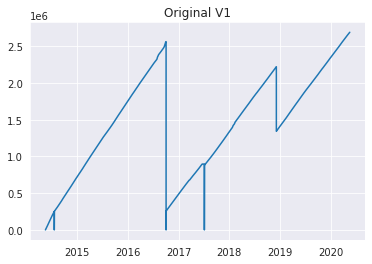

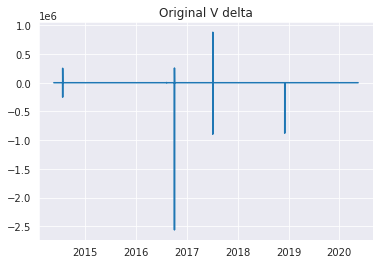

In [8]:
plt.plot(df_main["mtime"], df_main["V1"])
plt.title("Original V1")
plt.show()

plt.plot(df_main["mtime"], df_main["V_delta"])
plt.title("Original V delta")
plt.show()

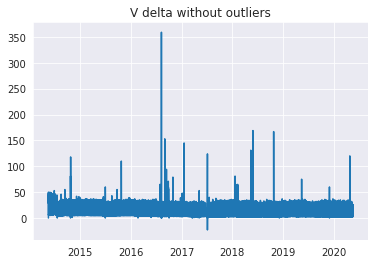

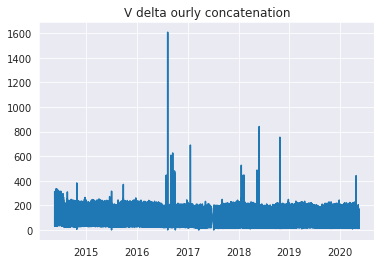

In [9]:
df_main.loc[(df_main.V_delta.abs() > 1e+3), "V_delta"] = 0

plt.plot(df_main["mtime"], df_main["V_delta"])
plt.title("V delta without outliers")
plt.show()

df_main = pd.concat([df_main.V_delta, df_main.mtime.dt.round("H")], axis=1).groupby("mtime").sum().reset_index()

plt.plot(df_main["mtime"], df_main["V_delta"])
plt.title("V delta ourly concatenation")
plt.show()

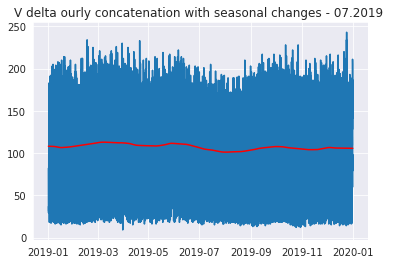

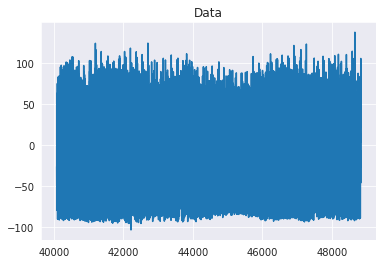

In [10]:
plt.plot(df_main.loc[(df_main.mtime.dt.year == 2019), "mtime"], df_main.loc[(df_main.mtime.dt.year == 2019), "V_delta"])


seasonal_changes = df_main.V_delta.rolling(24 * 42, center=True, min_periods=2).mean().rolling(24 * 7, center=True, min_periods=2).mean()[(df_main.mtime.dt.year == 2019)]

plt.plot(df_main.loc[(df_main.mtime.dt.year == 2019), "mtime"], seasonal_changes , color = "red")
plt.title("V delta ourly concatenation with seasonal changes - 07.2019 ")
plt.show()

data = df_main.V_delta[(df_main.mtime.dt.year == 2019)] - seasonal_changes

plt.plot(data)
plt.title("Data")

lengths = np.array([24 * 7 for _ in range(data.shape[0] // (24 * 7))] + [
    data.shape[0] - (data.shape[0] // (24 * 7)) * 24 * 7])
Y_true = data.values.reshape(-1, 1)

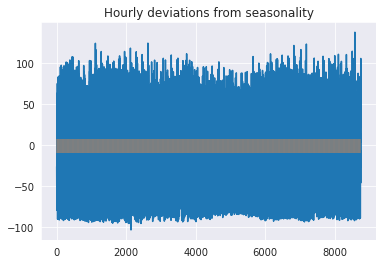

In [11]:
plt.plot(Y_true)
plt.title("Hourly deviations from seasonality")
plt.vlines(np.array([24*i for i in range(Y_true.shape[0] // 24)]), -10, 7.5, color='grey')
plt.show()

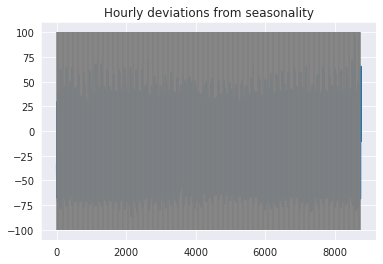

In [12]:
plt.plot(pd.Series(Y_true[:, 0]).rolling(6, center=True, min_periods=2).mean())
plt.title("Hourly deviations from seasonality")
plt.vlines(np.array([24*i for i in range(Y_true.shape[0] // 24)]), -100, 100, color='grey')
plt.show()

In [13]:
print(Y_true.shape)
Y_true = pd.Series(Y_true[:, 0]).rolling(6, center=True, min_periods=2).mean().values.reshape(-1, 1)
print(Y_true.shape)

(8760, 1)
(8760, 1)


# Build model

In [14]:
n = 10
l = 4
lr = 0.03271365590433669
ITER = 714450


lr = 0.1
ITER = 70000

TOLERANCE = 1e-4

def em_scheduler(max_lr, it):
    if it <= np.ceil(2 * ITER / 3):
        return max_lr * np.cos((np.ceil(ITER * 2 / 3) - it / 2) / ITER * np.pi * .67)
    else:
        return max_lr * np.cos(3 * (np.ceil(ITER * 2 / 3) - it) * np.pi * .33 / ITER)  ** 3


mstep_cofig = {"cooc_lr": lr, "cooc_epochs": ITER, "l_uz": l,
               'loss_type': 'square', "scheduler": em_scheduler}

t = time.localtime()

true_values = None

wandb_params = {
    "init": {
        "project": "gaussian-dense-hmm-wodociagi",
        "entity": "cirglaboratory",
        "save_code": True,
        "group": f"first-runs-2",
        "job_type": f"{t.tm_year}-{t.tm_mon}-{t.tm_mday}",
        "name": f"test3",
        "reinit": True
    },
    "config": {
        "n": n,
        "s": len(lengths),
        "T": lengths.max(),
        "model": None,
        "m": None,
        "l": None,
        "lr": lr,
        "em_epochs": None,
        "em_iter": None,
        "cooc_epochs": ITER,
        "simple_model": None
    }
}


mstep_cofig = {"cooc_lr": lr, "cooc_epochs": ITER, "l_uz": l,
               'loss_type': 'square', "scheduler": em_scheduler}

In [15]:
hmm_monitor = DenseHMMLoggingMonitor(tol=TOLERANCE, n_iter=0, verbose=True,
                                wandb_log=True, wandb_params=wandb_params, true_vals=true_values,
                                log_config={'metrics_after_convergence': True})
densehmm = GaussianDenseHMM(n, mstep_config=mstep_cofig,
                            covariance_type='full', opt_schemes={"cooc"},
                            logging_monitor=hmm_monitor,
                            init_params="stmc", params="stmc", early_stopping=True)

wandb: Currently logged in as: kabalce (cirglaboratory). Use `wandb login --relogin` to force relogin


In [16]:
start = time.perf_counter()
densehmm.fit_coocs(Y_true,lengths)
time_tmp = time.perf_counter() - start

2022-09-20 14:47:39.496490: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-20 14:47:39.496531: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-20 14:47:39.496558: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cymestmp): /proc/driver/nvidia/version does not exist
2022-09-20 14:47:39.499845: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-20 14:47:39.520333: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization p

In [17]:
# densehmm_org_aparms = densehmm
# densehmm_100k = densehmm
# densehmm_200k = densehmm
# densehmm_700k = densehmm
# densehmm_500k = densehmm

# Results

## Embeddings movement

In [18]:
z_init = np.transpose(hmm_monitor.z[-1])
pca_z = PCA(n_components=2).fit(z_init)
z = [pca_z.transform(z_init)] + [pca_z.transform(np.transpose(x)) for x in hmm_monitor.z]

z0 = list(hmm_monitor.z0)

u_init = hmm_monitor.u[-1]
pca_u = PCA(n_components=2).fit(u_init)
u = [pca_u.transform(u_init)] + [pca_u.transform(x) for x in hmm_monitor.u]

In [19]:
# Draw embeddings trajectories

def draw_embeddings(embeding_list, name="?"):
    fig = plt.figure(figsize=(5, 5))
    camera = Camera(fig)
    cmap = cm.rainbow(np.linspace(0, 1, len(embeding_list[0])))
    for z_el in embeding_list:
        if z_el.shape[1] > 1:
            plt.scatter(z_el[:, 0], z_el[:, 1], color=cmap)
        else:
            plt.scatter(np.arange(z_el.shape[0]), z_el, color=cmap)
        camera.snap()
    plt.title(f"Embaddings trajectory:  {name}")
    animation = camera.animate().to_html5_video()
    wandb.log({f"Embaddings trajectory:  {name}": wandb.Html(animation)})
    display(HTML(animation))
    plt.close()

In [20]:
draw_embeddings(z, "z")
draw_embeddings(z0, "z0")
draw_embeddings(u, "u")

## Embedding similarities

In [21]:
# Draw graph scaled with width and alpha
representation = densehmm.get_representations()

In [22]:
u_fin, z_fin, z0_fin = representation

In [23]:
u_fin

array([[ 1.95766552,  0.80902486,  1.58781307],
       [-1.30672601,  0.21545906, -0.14980594],
       [-0.80299663,  0.83552126,  0.87437611],
       [ 1.00301141, -0.50279052,  0.72646462],
       [-0.78801671,  0.93820063,  1.05084164],
       [ 1.31334526,  1.50090603,  2.27847896]])

In [24]:
z_fin

array([[ 1.59769867, -1.16510853, -1.04435068,  1.28070654, -2.6147476 ,
         0.38388841],
       [-0.12993698,  0.21438918,  0.29897276, -2.03509579,  0.85423201,
         1.11633982],
       [ 0.27913429, -1.09820093,  1.88333918,  0.5083246 ,  0.661887  ,
         0.56555046]])

In [25]:
z0_fin

array([[ 0.52741737],
       [-1.00296307],
       [ 0.77947458]])

In [26]:
np.matmul(u_fin, z_fin)

array([[ 3.46585041, -3.85118441,  1.18777763,  1.66787639, -3.37675345,
         2.55266018],
       [-2.15756649,  1.73318674,  1.1469612 , -2.18816241,  3.50165613,
        -0.34583426],
       [-1.14744341,  0.15446429,  2.73515497, -2.28430195,  3.39210071,
         1.11896837],
       [ 1.87062226, -2.07421412,  0.17036295,  2.67706998, -2.57128395,
         0.23461177],
       [-1.08759428, -0.0347702 ,  3.08255346, -2.38437766,  3.55744425,
         1.33914422],
       [ 2.53930838, -3.71063947,  3.36828569, -0.21427078, -0.64384878,
         3.46829402]])

In [27]:
z0_fin_red = z0[-1]
z_fin_red = z[-1]
u_fin_red = u[-1]

In [28]:
A_trained = np.exp(np.matmul(u_fin, z_fin)) / np.exp(np.matmul(u_fin, z_fin)).sum(axis=1).reshape(-1, 1)

In [29]:
A_largest = A_trained * (A_trained == A_trained.max(axis=1).reshape(-1, 1))

In [30]:
A_largest

array([[0.5984121 , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.77296777,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.59709259,
        0.        ],
       [0.        , 0.        , 0.        , 0.61394099, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.56480564,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.42697135]])

In [31]:
import itertools

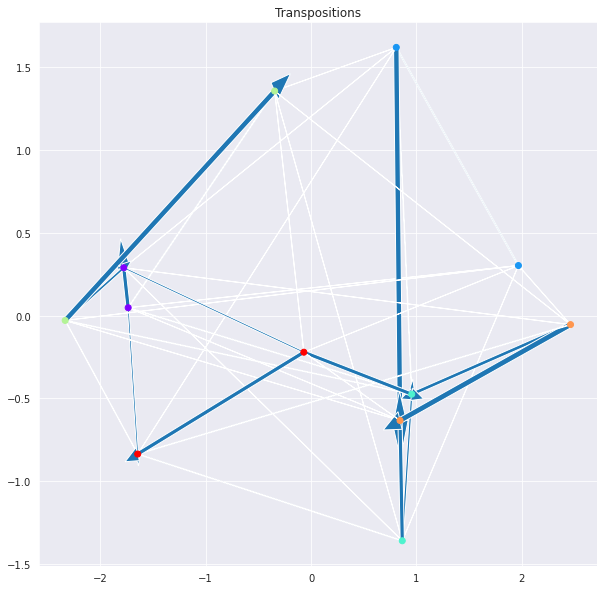

In [32]:
plt.figure(figsize=(10, 10))

for i, j in itertools.product(range(n), range(n)):
    plt.arrow(z_fin_red[i, 0], z_fin_red[i, 1], u_fin_red[j, 0] - z_fin_red[i, 0], u_fin_red[j, 1] - z_fin_red[i, 1], width=A_trained[i, j]/15)

plt.scatter(z_fin_red[:, 0], z_fin_red[:, 1], color = cm.rainbow(np.linspace(0, 1, n)))
plt.scatter(u_fin_red[:, 0], u_fin_red[:, 1], color = cm.rainbow(np.linspace(0, 1, n)))

plt.title("Transpositions")
plt.show()

In [33]:
z_fin_red

array([[-1.7352991 ,  0.04724937],
       [ 0.80885947,  1.61959498],
       [ 0.86550166, -1.36055769],
       [-2.33306829, -0.0297751 ],
       [ 2.4621978 , -0.0548497 ],
       [-0.06819154, -0.22166186]])

In [34]:
uz_fin = np.concatenate([u_fin, np.transpose(z_fin)], axis=1)

In [35]:
pca_uz = PCA(n_components=2)
uz_fin_red = pca_uz.fit_transform(uz_fin)

In [36]:
uz_fin_red

array([[-2.51209616,  0.52019006],
       [ 1.81798159, -1.52393909],
       [ 1.28239415,  0.33201879],
       [-2.18741571, -1.8442462 ],
       [ 2.57297485,  0.58291867],
       [-0.97383872,  1.93305777]])

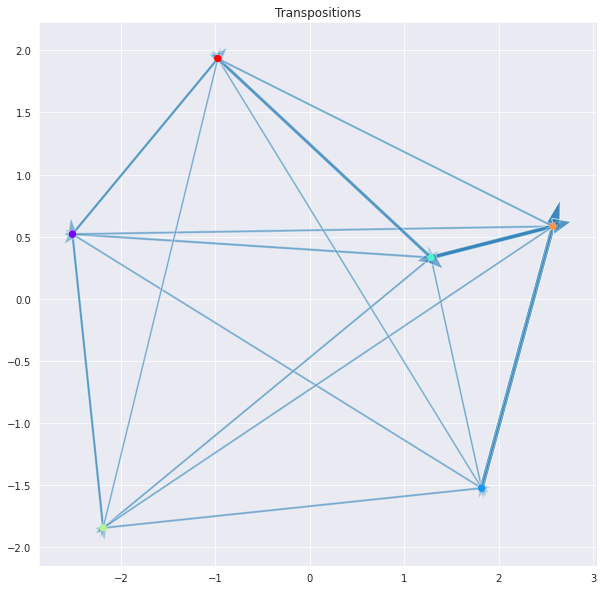

In [37]:
plt.figure(figsize=(10, 10))

for i, j in itertools.product(range(n), range(n)):
    if i == j:
        continue
    plt.arrow(uz_fin_red[i, 0], uz_fin_red[i, 1], uz_fin_red[j, 0] - uz_fin_red[i, 0], uz_fin_red[j, 1] - uz_fin_red[i, 1], width=(A_trained[i, j] / 1.5 + 0.33) * 0.06, alpha=A_trained[i, j] / 1.5 + 0.33)  #, color=cm.rainbow(A_trained[i, j] )

plt.scatter(uz_fin_red[:, 0], uz_fin_red[:, 1], color = cm.rainbow(np.linspace(0, 1, n)))
plt.scatter(uz_fin_red[:, 0], uz_fin_red[:, 1], color = cm.rainbow(np.linspace(0, 1, n)))

plt.title("Transpositions")
plt.show()

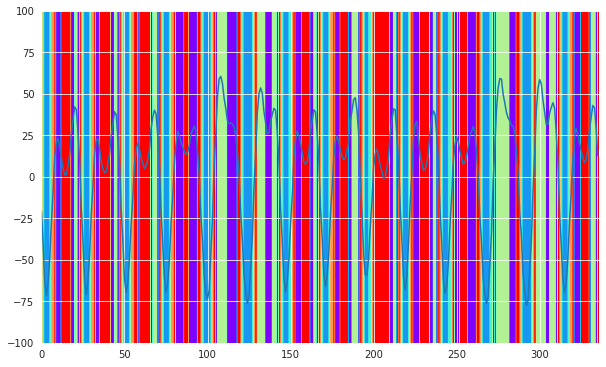

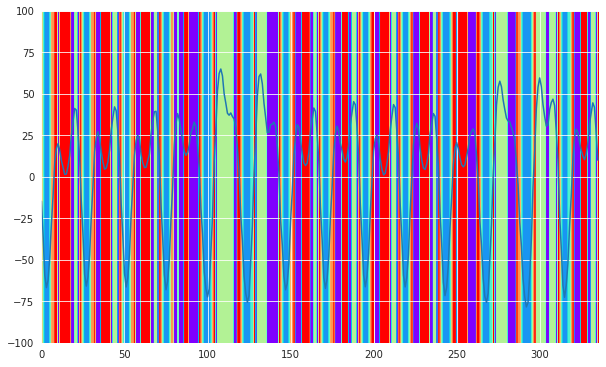

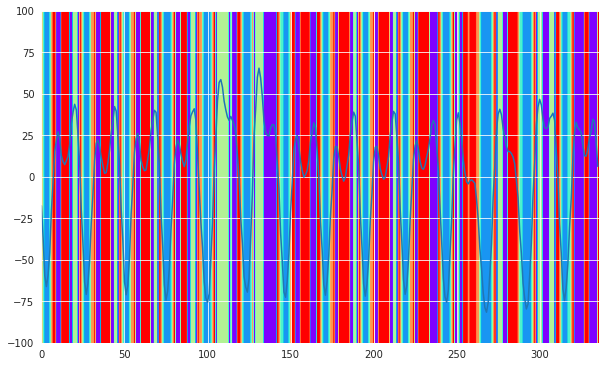

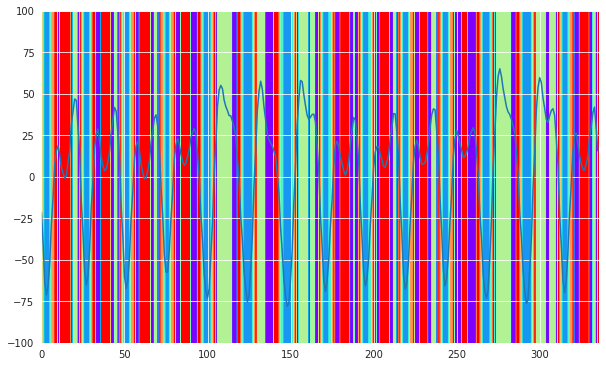

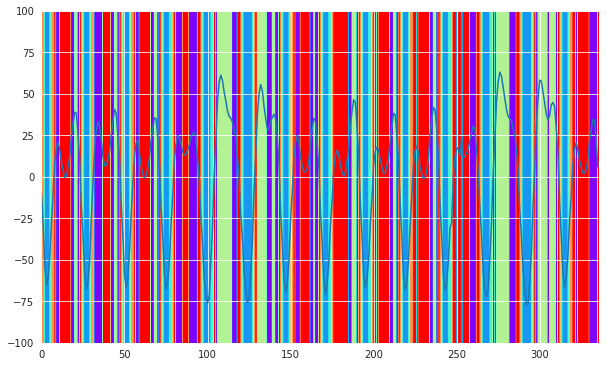

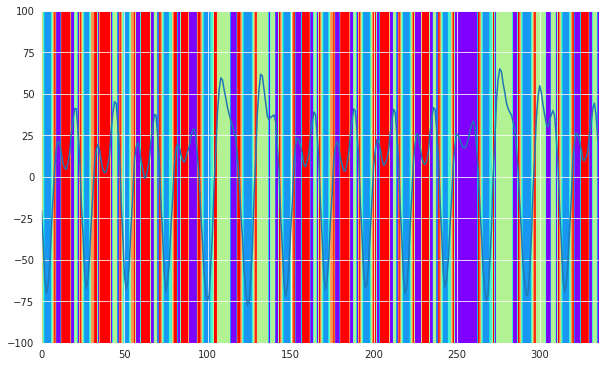

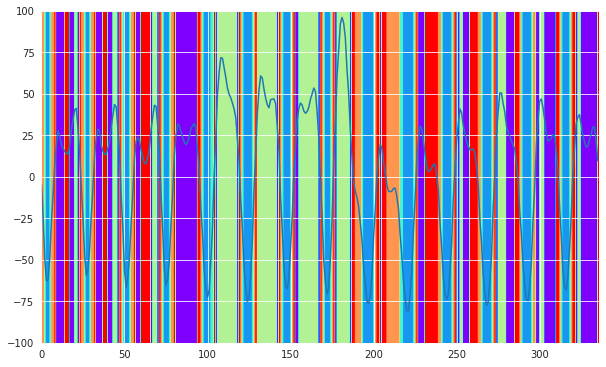

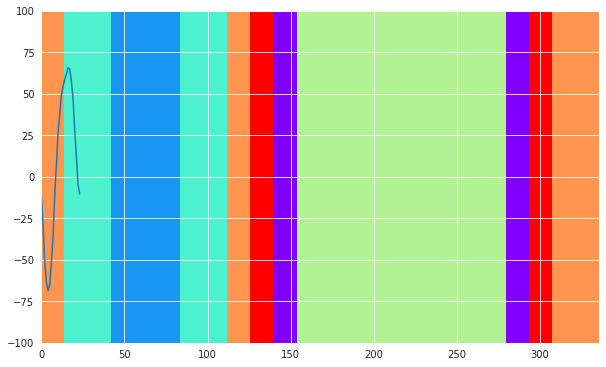

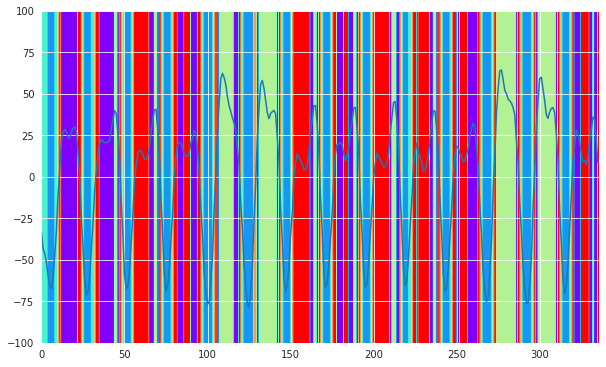

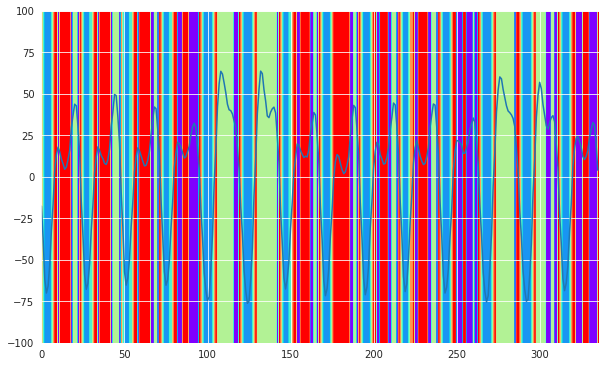

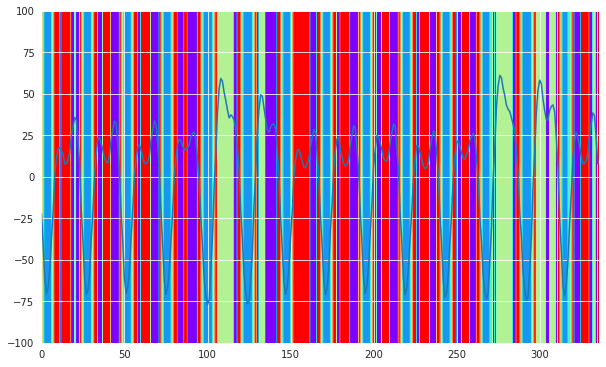

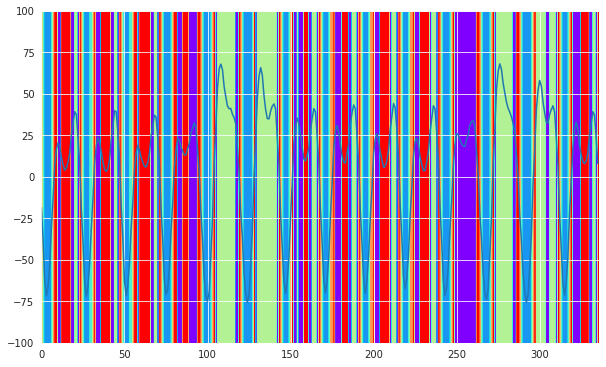

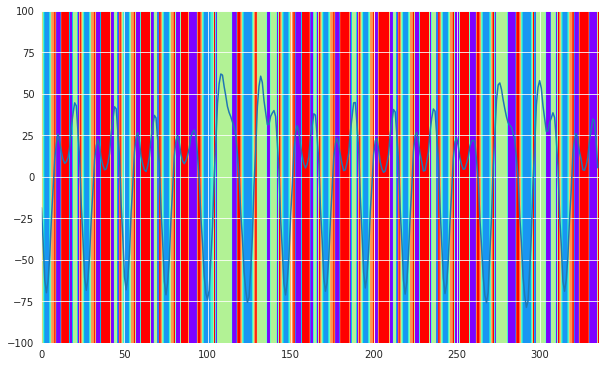

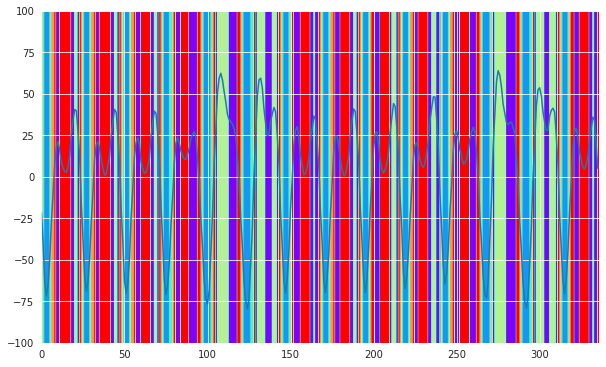

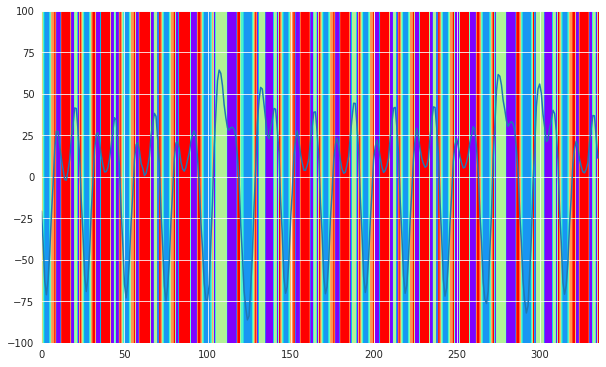

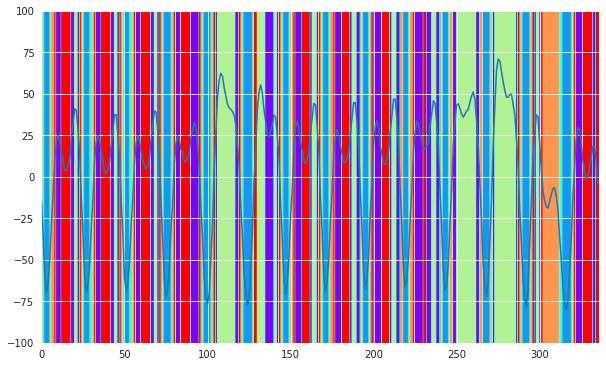

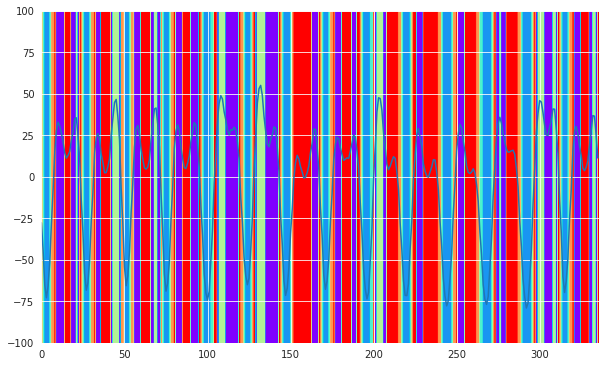

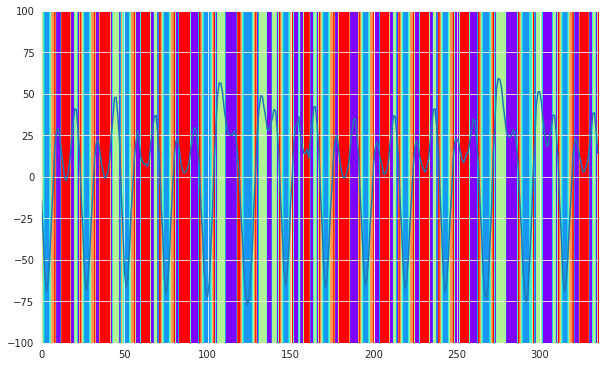

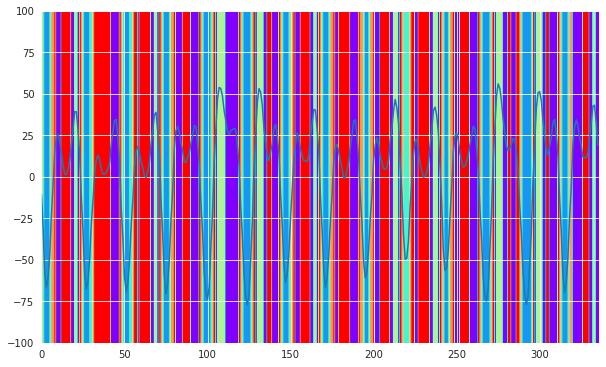

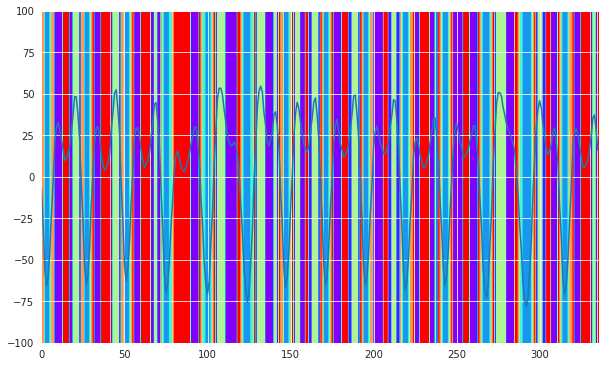

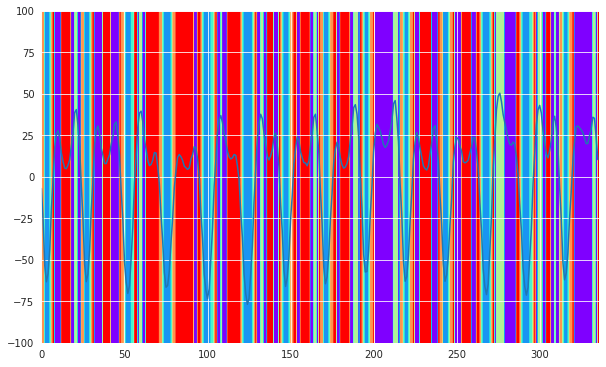

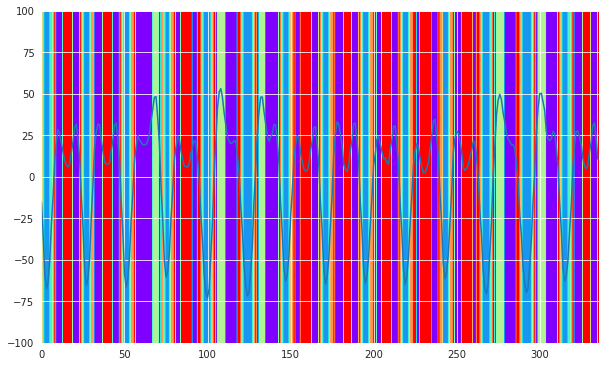

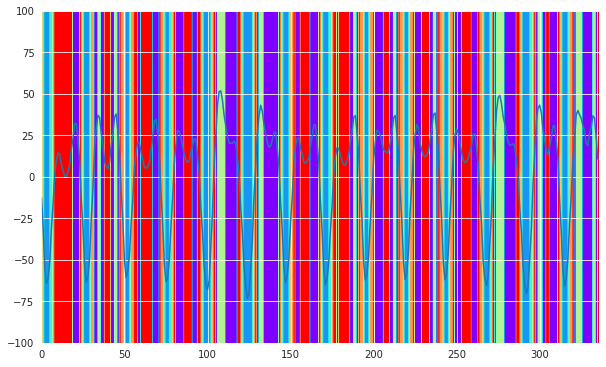

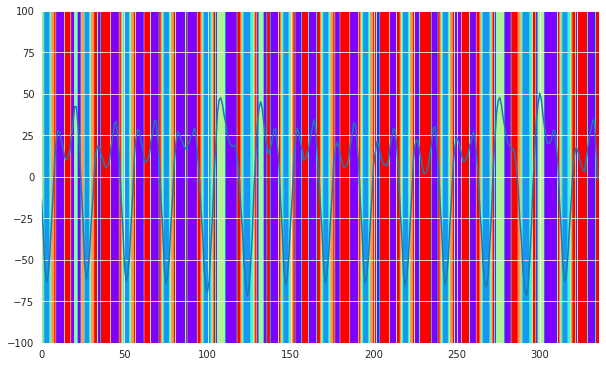

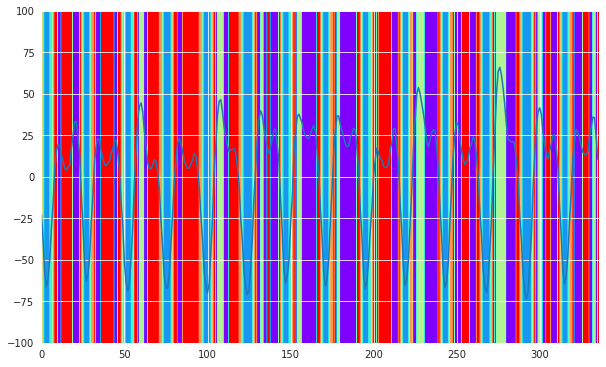

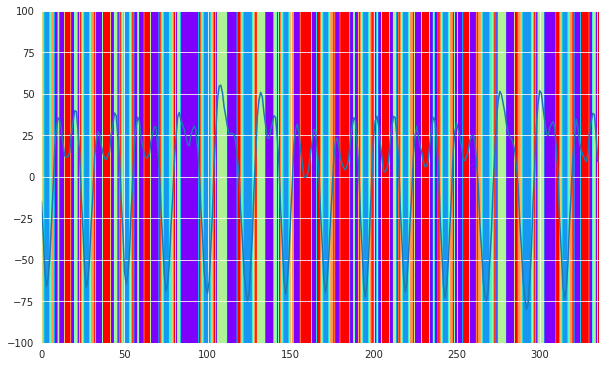

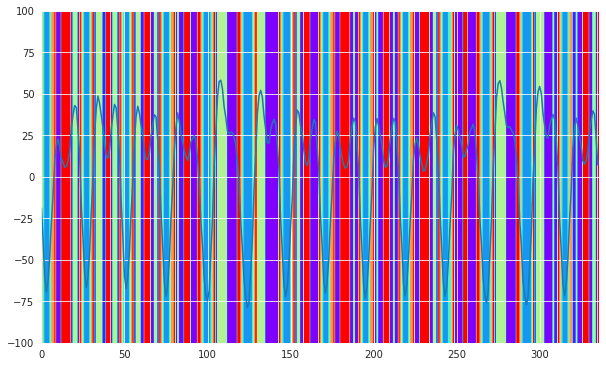

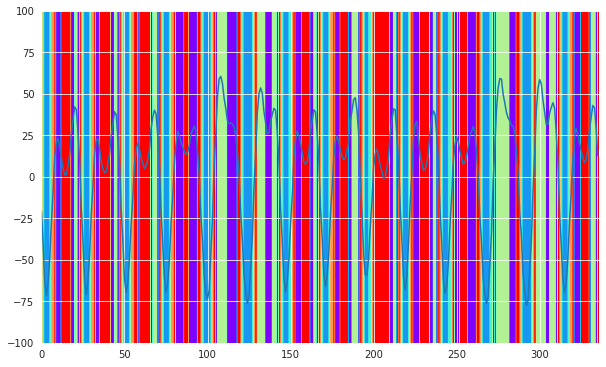

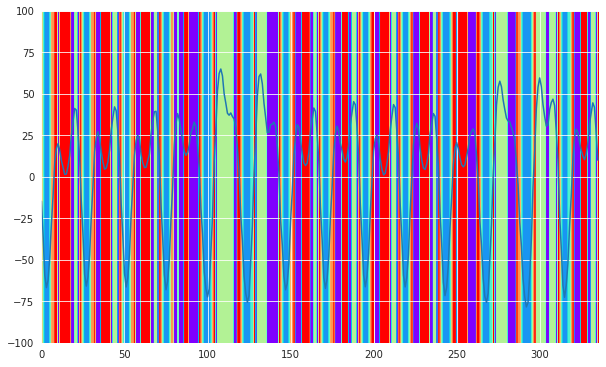

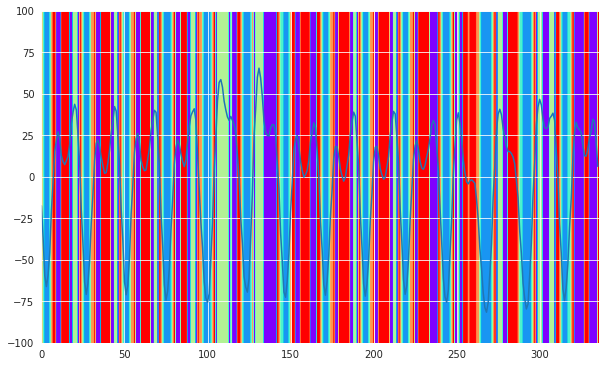

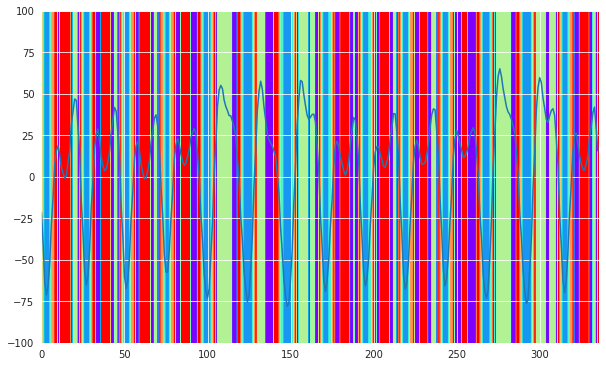

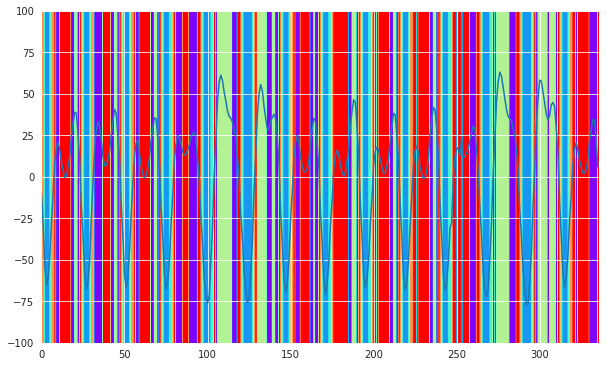

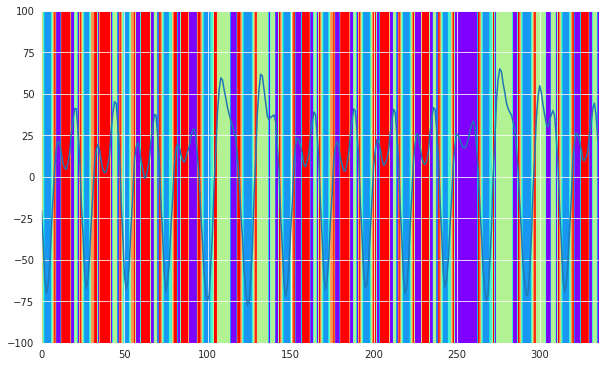

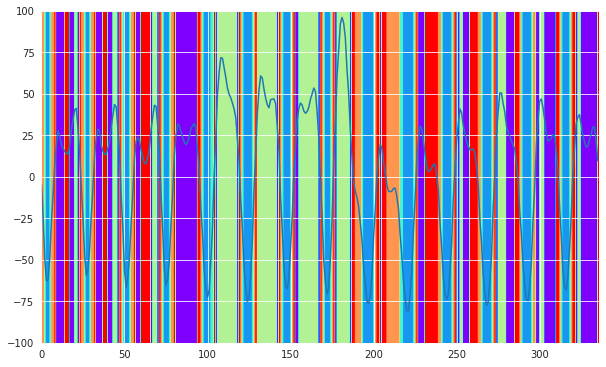

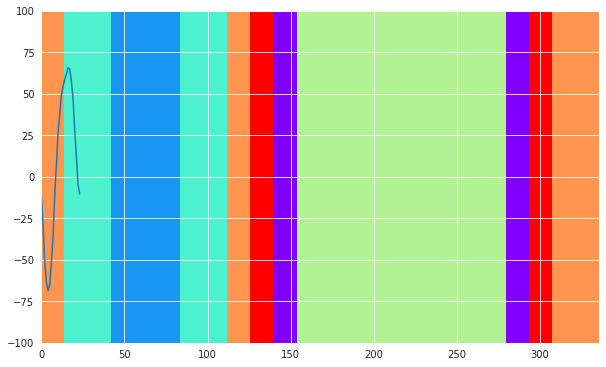

In [40]:
states = densehmm.predict(Y_true).reshape(1, -1)

interval = 7 * 24

for i in range(Y_true.shape[0] // (interval) + 1):
    plt.figure(figsize=(10, 10))
    plt.plot(Y_true[(i*interval) : ((i+1)*interval)])
    plt.imshow(states[:, (i*interval) : ((i+1)*interval)], extent=(0, Y_true[(i*interval) : ((i+1)*interval)].shape[0], -100, 100), cmap=cm.rainbow)
    plt.show()

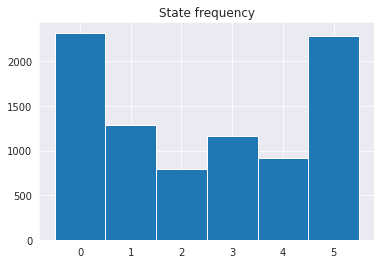

In [48]:
plt.hist(densehmm.predict(Y_true).reshape(-1), [i - 0.5 for i in range(n+1)])
plt.title("State frequency")
plt.show()

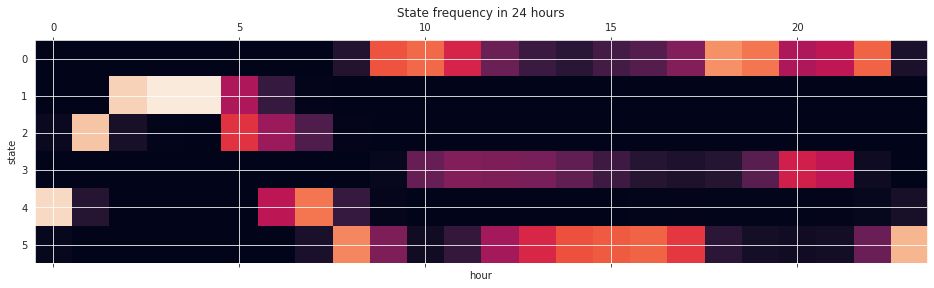

In [49]:
plt.matshow(pd.DataFrame({"states": states.reshape(-1), "hour": np.arange(states.shape[1]) % 24 }).value_counts().reset_index().sort_values(["states", "hour"]).pivot("states", "hour", 0).fillna(0).values)
plt.ylabel("state")
plt.xlabel("hour")
plt.title("State frequency in 24 hours")
plt.show()